In [170]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline

In [2]:
#import warnings
#warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [5]:
TRAIN_DATASET_PATH = 'real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = 'real-estate-price-prediction-moscow/test.csv'

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [176]:
test_df_orig = pd.read_csv(TEST_DATASET_PATH)
test_df_orig.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


## Приведение типов

In [8]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [9]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

## Обзор данных

#### Целевая переменная

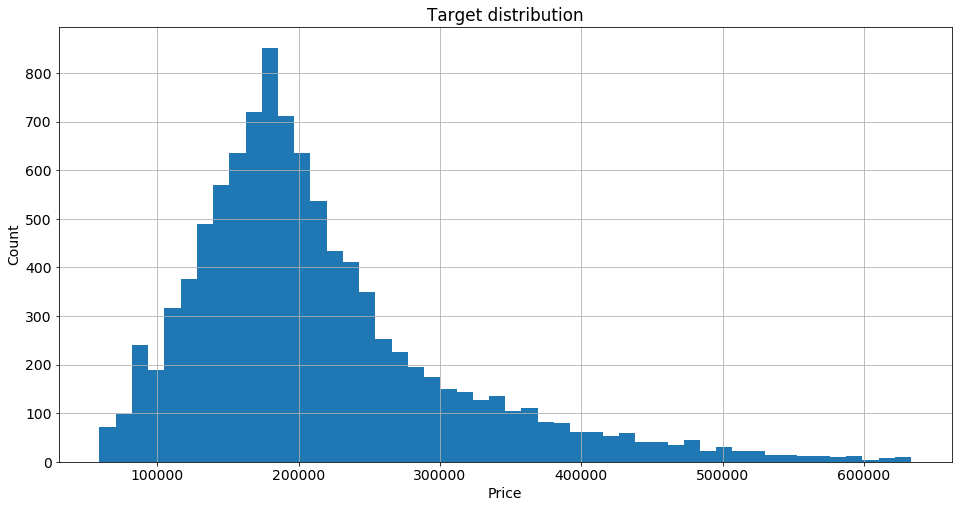

In [10]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

#### Количественные переменные

In [11]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


#### Номинативные переменные

In [12]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [13]:
train_df['DistrictId'].value_counts().head()

27    851
1     652
23    565
6     511
9     294
Name: DistrictId, dtype: int64

In [14]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [15]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [16]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

## Обработка выбросов

#### Rooms

In [17]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [18]:
train_df.loc[train_df['Rooms'].isin([0, 10, 19]), 'Rooms'] = train_df['Rooms'].median()

In [19]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.888800,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.812096,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,1.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,6.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


#### Square	LifeSquare	KitchenSquare

In [20]:
train_df['Square'].sort_values()

7470      1.136859
4496      1.988943
9869      2.377248
8572      2.596351
161       2.954309
           ...    
7644    212.932361
1906    275.645284
7010    409.425181
726     604.705972
9229    641.065193
Name: Square, Length: 10000, dtype: float64

In [21]:
train_df.loc[train_df['Square'] < 15, 'Square'] = 15
train_df.loc[train_df['Square'] > 200, 'Square'] = 200

In [22]:
train_df['LifeSquare'].sort_values()

3113    0.370619
1829    0.641822
119     0.795539
9869    0.873147
6882    1.049867
          ...   
9975         NaN
9978         NaN
9981         NaN
9983         NaN
9991         NaN
Name: LifeSquare, Length: 10000, dtype: float64

In [23]:
train_df.loc[train_df['LifeSquare'] < 10, 'LifeSquare'] = 10
train_df.loc[train_df['LifeSquare'] > 120, 'LifeSquare'] = 120

In [24]:
train_df['LifeSquare'].median()

32.78126019215573

In [25]:
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] = train_df['LifeSquare'].median()

In [26]:
train_df['KitchenSquare'].sort_values()

2178       0.0
5612       0.0
519        0.0
8814       0.0
3709       0.0
         ...  
7733     112.0
5002     112.0
286      123.0
6505    1970.0
9520    2014.0
Name: KitchenSquare, Length: 10000, dtype: float64

In [27]:
train_df.loc[train_df['KitchenSquare'] < 2, 'KitchenSquare'] = 2
train_df.loc[train_df['KitchenSquare'] > 40, 'KitchenSquare'] = 40

In [28]:
mask = train_df['Square'] < (train_df['LifeSquare']  + train_df['KitchenSquare']) 
train_df.loc[mask].describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,367.000000,1070.000000,1070.000000,1070.000000
mean,1.698131,55.879510,55.696053,5.713084,9.751402,14.146729,1998.907477,0.103952,15.040187,3479.344860,8.505607,866.212534,0.799065,3.382243,188850.792348
std,0.796094,19.883685,20.255543,7.000128,5.909504,8.373639,19.848157,0.110801,16.576022,3843.801538,28.600167,693.488031,1.312600,5.234864,94721.434139
min,1.000000,15.000000,10.000000,2.000000,1.000000,0.000000,1918.000000,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000,59877.592523
25%,1.000000,40.717959,40.490641,2.000000,5.000000,9.000000,1977.000000,0.011654,2.000000,475.000000,0.000000,540.000000,0.000000,0.000000,125242.802612
50%,1.500000,51.854203,51.069611,2.000000,9.000000,17.000000,2014.000000,0.069753,6.000000,1564.000000,1.000000,705.000000,0.000000,1.000000,167863.443794
75%,2.000000,66.793630,66.870250,10.000000,14.000000,17.000000,2017.000000,0.195781,25.000000,5735.000000,3.000000,1046.000000,1.000000,5.000000,221711.384860
max,5.000000,138.980817,120.000000,40.000000,28.000000,117.000000,2020.000000,0.486246,74.000000,19083.000000,141.000000,4508.000000,6.000000,23.000000,621002.912679


In [29]:
train_df.loc[mask, 'Square'] = train_df['LifeSquare'] + train_df['KitchenSquare']

In [30]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.888800,56.806715,35.463690,6.202400,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.812096,19.417236,15.232359,3.978871,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,1.000000,15.000000,10.000000,2.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,42.250933,25.527399,2.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,53.033342,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,66.483752,41.427234,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,6.000000,200.000000,120.000000,40.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


#### Floor	HouseFloor

No handles with labels found to put in legend.


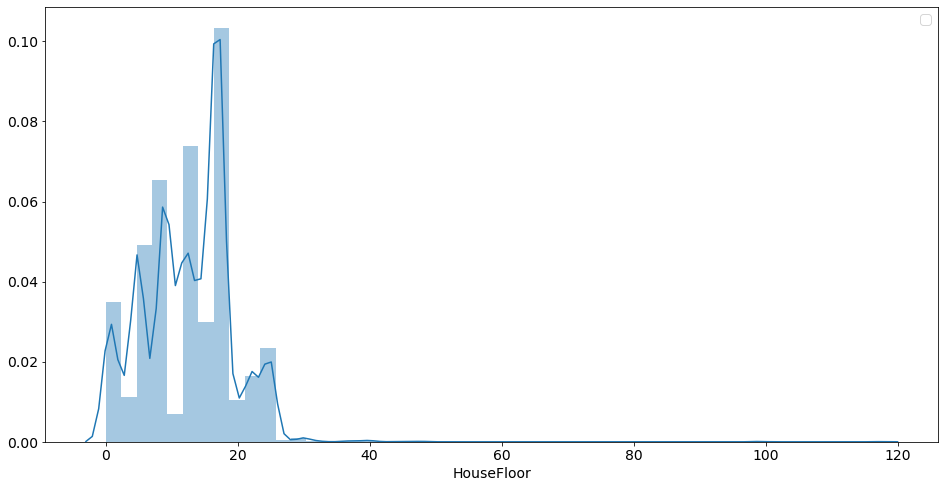

In [31]:
plt.figure(figsize = (16, 8))

sns.distplot(train_df['HouseFloor'], bins=50)

plt.legend()
plt.show()

In [32]:
train_df['HouseFloor'].sort_values()

2768      0.0
1928      0.0
5104      0.0
6870      0.0
6860      0.0
        ...  
5031     48.0
4987     48.0
746      99.0
4657     99.0
1678    117.0
Name: HouseFloor, Length: 10000, dtype: float64

In [33]:
train_df.loc[train_df['HouseFloor'] > 40, 'HouseFloor'] = 40

In [34]:
mask_floor = train_df['Floor'] > train_df['HouseFloor']
train_df.loc[mask_floor].describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,1826.000000,1826.000000,1826.000000,1826.00000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,862.000000,1826.000000,1826.000000,1826.000000
mean,1.892114,59.517796,36.451366,4.73713,10.730011,6.203724,1983.417853,0.110267,21.002738,4599.401972,9.076670,1107.163573,1.208653,3.972618,211838.232649
std,0.819538,21.805577,17.510008,4.09596,5.806274,6.362054,18.806064,0.110828,17.033971,3824.270012,27.272559,988.111606,1.487391,5.140792,96167.940536
min,1.000000,15.000000,10.000000,2.00000,1.000000,0.000000,1914.000000,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000,60828.260686
25%,1.000000,43.371811,29.402176,2.00000,6.000000,1.000000,1976.000000,0.017647,2.250000,637.250000,0.000000,520.000000,0.000000,0.000000,149042.004310
50%,2.000000,55.789298,32.781260,2.00000,10.000000,5.000000,1977.000000,0.072158,22.000000,4724.000000,1.000000,990.000000,1.000000,2.000000,188119.834006
75%,2.000000,70.600206,40.539091,7.00000,15.000000,9.000000,1994.000000,0.174739,32.000000,6398.000000,4.000000,1450.000000,2.000000,5.000000,242090.207480
max,5.000000,200.000000,120.000000,40.00000,42.000000,40.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,627525.072788


In [35]:
train_df.loc[mask_floor, 'HouseFloor'] = train_df['Floor']

In [36]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.888800,56.806715,35.463690,6.202400,8.526700,13.413200,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.812096,19.417236,15.232359,3.978871,5.241148,5.884754,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,1.000000,15.000000,10.000000,2.000000,1.000000,1.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,42.250933,25.527399,2.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,53.033342,32.781260,6.000000,7.000000,14.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,66.483752,41.427234,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,6.000000,200.000000,120.000000,40.000000,42.000000,42.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


#### HouseYear

In [37]:
train_df['HouseYear'].sort_values()

6794        1910
2795        1912
2066        1912
6250        1914
7610        1916
          ...   
8296        2020
2350        2020
7246        2020
8828        4968
9163    20052011
Name: HouseYear, Length: 10000, dtype: int64

In [38]:
train_df.loc[train_df['HouseYear'] == 20052011, 'HouseYear'] = 2008
train_df.loc[train_df['HouseYear'] == 4968, 'HouseYear'] = 1968

## Заполнение пропусков

In [39]:
train_df.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [40]:
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

No handles with labels found to put in legend.


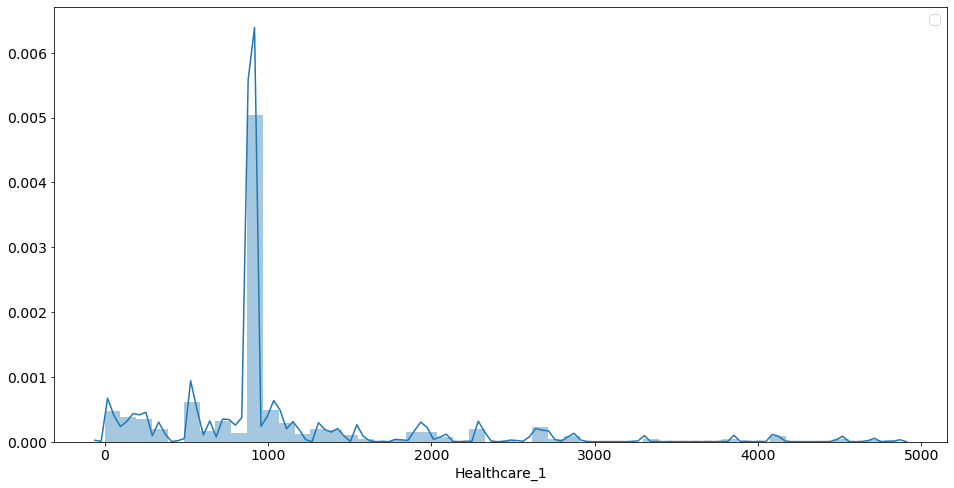

In [41]:
plt.figure(figsize = (16, 8))

sns.distplot(train_df['Healthcare_1'], bins=50)

plt.legend()
plt.show()

## Построение новых признаков

In [42]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     10000 non-null  float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   10000 non-null  float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

#### Dummies

In [43]:
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A':0, 'B':1})

#### District

In [65]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294
...,...,...
200,207,1
201,196,1
202,199,1
203,209,1


In [66]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,11809,27,3.0,115.027311,32.781260,10.0,4,10.0,2014,0.075424,...,0,900.0,0,0,B,305018.871089,1,1,1,851
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,1183.0,1,0,B,177734.553407,1,1,1,78
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,0,240.0,3,1,B,282078.720850,1,1,1,652
3,2352,1,1.0,40.409907,32.781260,2.0,10,22.0,1977,0.007122,...,0,900.0,0,1,B,168106.007630,1,1,1,652
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,2,900.0,0,6,B,343995.102962,1,1,1,89


#### Median price by district and square

In [68]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                        .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202666.310126


In [69]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,MedPriceByDistrict
0,11809,27,3.0,115.027311,32.781260,10.0,4,10.0,2014,0.075424,...,900.0,0,0,B,305018.871089,1,1,1,851,213530.788443
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1183.0,1,0,B,177734.553407,1,1,1,78,146032.829834
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,240.0,3,1,B,282078.720850,1,1,1,652,244005.272380
3,2352,1,1.0,40.409907,32.781260,2.0,10,22.0,1977,0.007122,...,900.0,0,1,B,168106.007630,1,1,1,652,146735.671740
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,900.0,0,6,B,343995.102962,1,1,1,89,201584.441255


In [70]:
med_price_by_square = train_df.groupby(['Square'], as_index=False).agg({'Price':'median'})\
                      .rename(columns={'Price':'MedPriceBySquare'})
med_price_by_square.head()

,Square,MedPriceBySquare
0,15.000000,181434.825589
1,16.117154,79913.267856
2,17.498542,88871.750230
3,18.509177,115845.861527
4,18.983962,112411.221700


In [73]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,MedPriceByDistrict
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.888800,56.806715,35.463690,6.202400,8.526700,13.413200,1984.86600,0.118858,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399,0.990300,0.972500,0.917500,242.306600,211504.274006
std,0.812096,19.417236,15.232359,3.978871,5.241148,5.884754,18.41187,0.119025,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865,0.098015,0.163543,0.275139,268.992652,76545.354083
min,1.000000,15.000000,10.000000,2.000000,1.000000,1.000000,1910.00000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,1.000000,82342.775873
25%,1.000000,42.250933,25.527399,2.000000,4.000000,9.000000,1974.00000,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942,1.000000,1.000000,1.000000,55.000000,165071.825722
50%,2.000000,53.033342,32.781260,6.000000,7.000000,14.000000,1977.00000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,1.000000,1.000000,1.000000,104.000000,195474.299127
75%,2.000000,66.483752,41.427234,9.000000,12.000000,17.000000,2001.00000,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171,1.000000,1.000000,1.000000,511.000000,241068.903045
max,6.000000,200.000000,120.000000,40.000000,42.000000,42.000000,2020.00000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,851.000000,624156.003381


## Отбор признаков

In [75]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'DistrictSize',
 'MedPriceByDistrict']

In [158]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin', 'DistrictSize']

target_name = 'Price'

## Разбиение на train и test

In [159]:
X = train_df[feature_names]
y = train_df[target_name]

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

## Построение модели

### Random Forest

In [49]:
# rf_model = RandomForestRegressor(criterion='mse',
#                                 random_state=42)

In [52]:
# params = {'n_estimators':[200, 400, 500, 600], 
#           'max_depth':[7, 10, 15, 20, 25, 30],
#          'min_samples_leaf': [5, 10, 20, 30]}

# gs = GridSearchCV(rf_model, params, 
#                   scoring='r2', # метрика 
#                   cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
#                            random_state=42, 
#                            shuffle=True),
#                   n_jobs=-1,
#                   verbose=10
#                   )
# gs.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   54.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  4

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose

In [53]:
# gs.best_params_

{'max_depth': 30, 'min_samples_leaf': 5, 'n_estimators': 600}

In [54]:
# gs.best_score_

0.705519217922897

In [161]:
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=30,   
                                 min_samples_leaf=5,
                                 random_state=42,
                                 n_estimators=600
                                 )

rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=600, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

Train R2:	0.874
Test R2:	0.73


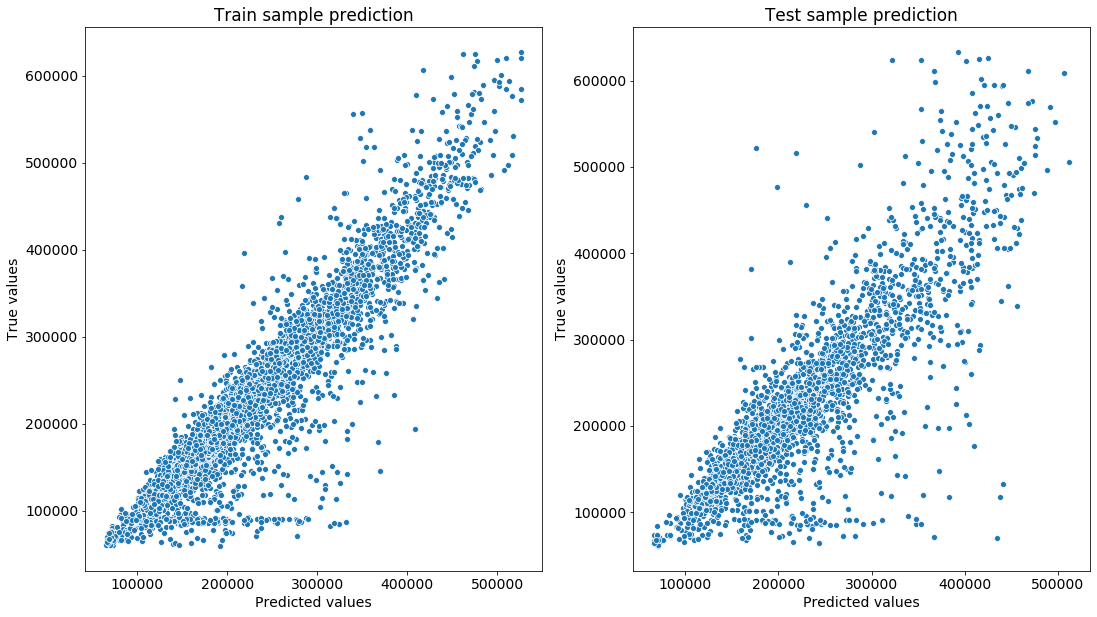

In [162]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

#### Перекрестная проверка

In [163]:
cv_score = cross_val_score(rf_model, X, y, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=42))
cv_score

array([0.73095428, 0.70589684, 0.74404133])

In [164]:
cv_score.mean()

0.7269641503292018

#### Важность признаков

In [61]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.393793
10,Social_1,0.125040
11,Social_2,0.107903
0,Rooms,0.086943
12,Social_3,0.063694
7,Ecology_1,0.046601
5,HouseFloor,0.028730
6,HouseYear,0.028311
3,KitchenSquare,0.026235
13,Healthcare_1,0.023031


## Прогнозирование на тестовом датасете

In [146]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,...,4378,0,1036.0,1,1,B,1,1,1,46
1,5925,62,1.0,52.568133,42.568133,10.0,7,17.0,2017,0.072158,...,629,1,900.0,0,0,A,1,1,0,122
2,960,27,2.0,59.463678,32.925087,9.0,19,19.0,1977,0.211401,...,1892,0,900.0,0,1,B,1,1,1,391
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,...,475,0,900.0,0,0,B,1,1,1,264
4,746,74,1.0,53.837056,32.925087,2.0,8,17.0,1977,0.309479,...,7715,4,990.0,0,6,B,1,1,1,61


In [149]:
test_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,MedPriceBySquare
count,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,13.000000
mean,8412.595400,51.279200,1.90780,57.051285,35.571287,6.184000,8.632000,13.379600,1984.392600,0.119874,...,5406.900000,8.262600,1029.396400,1.31940,4.242800,0.990400,0.970200,0.917600,115.537200,187709.739191
std,4832.674037,44.179466,0.81008,19.184961,15.085316,3.850806,5.483228,6.106534,18.573149,0.120070,...,4026.614773,23.863762,766.595258,1.47994,4.777365,0.097518,0.170052,0.275001,127.381882,36474.379029
min,1.000000,0.000000,1.00000,15.000000,10.000000,2.000000,1.000000,1.000000,1908.000000,0.000000,...,168.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,104891.073757
25%,4221.750000,21.000000,1.00000,42.365984,25.850152,2.000000,4.000000,9.000000,1973.000000,0.019509,...,1564.000000,0.000000,810.000000,0.00000,1.000000,1.000000,1.000000,1.000000,27.000000,181434.825589
50%,8320.500000,37.000000,2.00000,53.526071,32.925087,6.000000,7.000000,14.000000,1977.000000,0.072158,...,5285.000000,2.000000,900.000000,1.00000,3.000000,1.000000,1.000000,1.000000,49.000000,181434.825589
75%,12598.250000,77.000000,2.00000,67.102985,41.769526,9.000000,12.000000,17.000000,2000.000000,0.195781,...,7287.000000,5.000000,990.000000,2.00000,6.000000,1.000000,1.000000,1.000000,257.000000,181434.825589
max,16795.000000,212.000000,6.00000,200.000000,120.000000,40.000000,78.000000,78.000000,2020.000000,0.521867,...,19083.000000,141.000000,4849.000000,6.00000,23.000000,1.000000,1.000000,1.000000,391.000000,244964.251712


### Обработка выбросов

#### Rooms

In [86]:
test_df['Rooms'].value_counts()

2.0     2030
1.0     1769
3.0     1099
4.0       90
5.0        7
0.0        2
6.0        2
17.0       1
Name: Rooms, dtype: int64

In [89]:
test_df.loc[test_df['Rooms'].isin([0, 17]), 'Rooms'] = test_df['Rooms'].median()

In [98]:
test_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.90780,56.459804,35.571287,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.81008,18.972591,15.085316,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,1.00000,15.000000,10.000000,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.00000,41.906231,25.850152,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.00000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.00000,66.285129,41.769526,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,6.00000,200.000000,120.000000,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


#### Square	LifeSquare	KitchenSquare

In [91]:
test_df['Square'].sort_values()

2463      1.378543
1672      1.975769
3608      2.372101
131       2.645046
571       2.900586
           ...    
1377    170.476326
4549    173.974480
4852    189.679576
4402    221.138768
956     223.453689
Name: Square, Length: 5000, dtype: float64

In [92]:
test_df.loc[test_df['Square'] < 15, 'Square'] = 15
test_df.loc[test_df['Square'] > 200, 'Square'] = 200

In [94]:
test_df['LifeSquare'].sort_values()

4088    0.333490
4397    0.567267
3284    0.809265
1537    0.863989
752     1.181139
          ...   
4985         NaN
4986         NaN
4988         NaN
4989         NaN
4993         NaN
Name: LifeSquare, Length: 5000, dtype: float64

In [95]:
test_df.loc[test_df['LifeSquare'] < 10, 'LifeSquare'] = 10
test_df.loc[test_df['LifeSquare'] > 120, 'LifeSquare'] = 120

In [96]:
test_df['LifeSquare'].median()

32.92508663208161

In [97]:
test_df.loc[test_df['LifeSquare'].isnull(), 'LifeSquare'] = test_df['LifeSquare'].median()

In [100]:
test_df['KitchenSquare'].sort_values()

885       0.0
4466      0.0
2308      0.0
2208      0.0
3294      0.0
        ...  
1224     62.0
4127     65.0
4342     97.0
4227    112.0
3750    620.0
Name: KitchenSquare, Length: 5000, dtype: float64

No handles with labels found to put in legend.


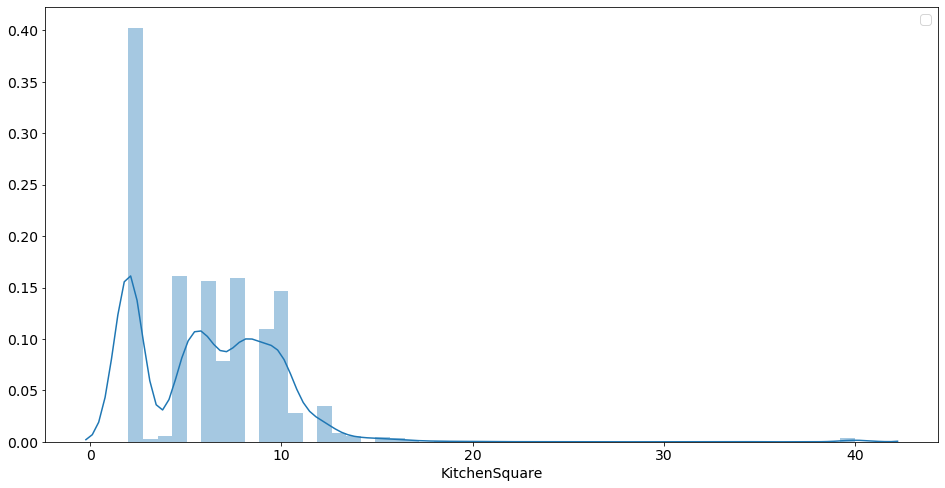

In [105]:
plt.figure(figsize = (16, 8))

sns.distplot(test_df['KitchenSquare'], bins=50)

plt.legend()
plt.show()

In [104]:
test_df.loc[test_df['KitchenSquare'] < 2, 'KitchenSquare'] = 2
test_df.loc[test_df['KitchenSquare'] > 40, 'KitchenSquare'] = 40

In [109]:
mask = test_df['Square'] < (test_df['LifeSquare']  + test_df['KitchenSquare']) 
test_df.loc[mask].describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
test_df.loc[mask, 'Square'] = test_df['LifeSquare'] + test_df['KitchenSquare']

In [112]:
test_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.90780,57.051285,35.571287,6.184000,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.81008,19.184961,15.085316,3.850806,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,1.00000,15.000000,10.000000,2.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.00000,42.365984,25.850152,2.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.00000,53.526071,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.00000,67.102985,41.769526,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,6.00000,200.000000,120.000000,40.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


#### Floor	HouseFloor

No handles with labels found to put in legend.


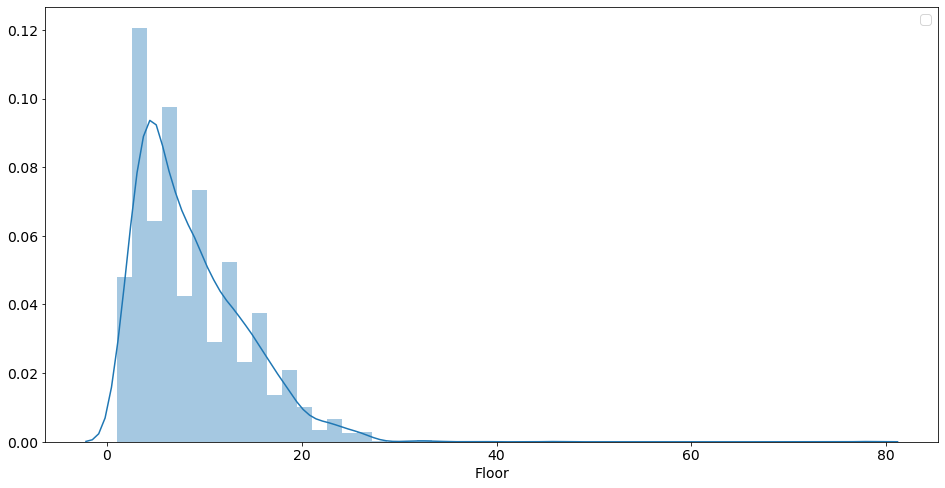

In [116]:
plt.figure(figsize = (16, 8))

sns.distplot(test_df['Floor'], bins=50)

plt.legend()
plt.show()

In [117]:
test_df.loc[test_df['HouseFloor'] > 40, 'HouseFloor'] = 40

In [120]:
mask_floor = test_df['Floor'] > test_df['HouseFloor']
test_df.loc[mask_floor].describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [119]:
test_df.loc[mask_floor, 'HouseFloor'] = test_df['Floor']

In [129]:
test_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.90780,57.051285,35.571287,6.184000,8.632000,13.379600,1984.392600,0.119874,24.933800,5406.900000,8.262600,1029.396400,1.31940,4.242800
std,4832.674037,44.179466,0.81008,19.184961,15.085316,3.850806,5.483228,6.106534,18.573149,0.120070,17.532202,4026.614773,23.863762,766.595258,1.47994,4.777365
min,1.000000,0.000000,1.00000,15.000000,10.000000,2.000000,1.000000,1.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.00000,42.365984,25.850152,2.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,810.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.00000,53.526071,32.925087,6.000000,7.000000,14.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.00000,67.102985,41.769526,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,990.000000,2.00000,6.000000
max,16795.000000,212.000000,6.00000,200.000000,120.000000,40.000000,78.000000,78.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


#### HouseYear

In [122]:
train_df['HouseYear'].sort_values()

6794    1910
2795    1912
2066    1912
6250    1914
7610    1916
        ... 
1004    2020
5641    2020
7721    2020
7207    2020
8664    2020
Name: HouseYear, Length: 10000, dtype: int64

No handles with labels found to put in legend.


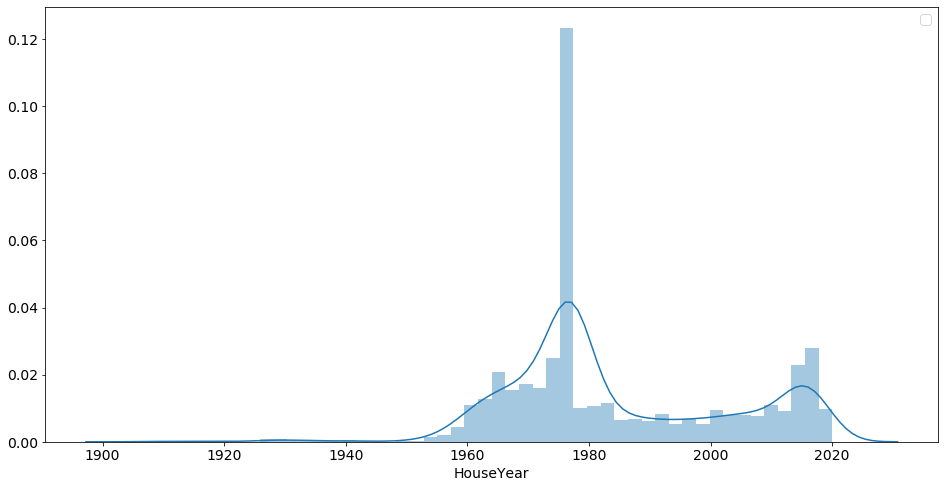

In [123]:
plt.figure(figsize = (16, 8))

sns.distplot(test_df['HouseYear'], bins=50)

plt.legend()
plt.show()

## Заполнение пропусков

In [128]:
test_df.isnull().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
dtype: int64

In [127]:
test_df.loc[test_df['Healthcare_1'].isnull(), 'Healthcare_1'] = test_df['Healthcare_1'].median()

## Построение новых признаков

In [144]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     5000 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   5000 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

#### Dummies

In [132]:
test_df['Ecology_2_bin'] = test_df['Ecology_2'].replace({'A':0, 'B':1})
test_df['Ecology_3_bin'] = test_df['Ecology_3'].replace({'A':0, 'B':1})
test_df['Shops_2_bin'] = test_df['Shops_2'].replace({'A':0, 'B':1})

#### District

In [134]:
district_size = test_df['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size

,DistrictId,DistrictSize
0,27,391
1,1,344
2,23,264
3,6,257
4,9,132
...,...,...
196,212,1
197,208,1
198,204,1
199,200,1


In [135]:
test_df = test_df.merge(district_size, on='DistrictId', how='left')
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,...,4378,0,1036.0,1,1,B,1,1,1,46
1,5925,62,1.0,52.568133,42.568133,10.0,7,17.0,2017,0.072158,...,629,1,900.0,0,0,A,1,1,0,122
2,960,27,2.0,59.463678,32.925087,9.0,19,19.0,1977,0.211401,...,1892,0,900.0,0,1,B,1,1,1,391
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,...,475,0,900.0,0,0,B,1,1,1,264
4,746,74,1.0,53.837056,32.925087,2.0,8,17.0,1977,0.309479,...,7715,4,990.0,0,6,B,1,1,1,61


### Отбор признаков

In [165]:
feature_names_pr = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin', 'DistrictSize']


### Предсказание цены

In [166]:
X1 = test_df[feature_names_pr]

In [171]:
filename = 'finalized_model.sav'
pickle.dump(rf_model, open(filename, 'wb'))

In [168]:
predicted = rf_model.predict(X1)

In [169]:
len(predicted)

5000

In [177]:
result = test_df_orig

In [178]:
result["Price"] = predicted

In [181]:
res = result[['Id', 'Price']]

In [183]:
 res.to_csv('VKudryavtseva_predictions.csv', index=False, sep = ',')